In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as la
from functions_parameters.universal_parameters import a, b
from itertools import product

In [2]:
final_result = np.load('u_v1_v2_t_4_em4_random_basis_mesh_60_pmap_over_filling.npz')


final_ground_state_e_diff_density = final_result['gse']
filling_arr = final_result['filling']
final_density = final_result['d']
final_bond = final_result['bond']
final_e_difference = final_result['e_diff']
final_c_difference = final_result['c_diff']
final_e_fermi = final_result['e_fermi']
final_iteration = final_result['iters']
any_bi_fail = final_result['any_bi_fail']

u_arr = final_result['u']
filling_mesh, u_mesh = np.meshgrid(filling_arr, u_arr, indexing = 'ij')

In [3]:
np.max(final_c_difference)

np.float64(0.00013136674935187997)

In [4]:
np.max(final_e_difference)

np.float64(1.4548593840757462e-07)

In [5]:
np.all(np.logical_not(any_bi_fail))

np.True_

### the convergence is not as good, but probably no need to delete any points right now

## Phase Analysis

In [6]:
from functions_parameters.tools import rot_symm_m_check_d
from functions_parameters.universal_parameters import pauli_matrices

c_6 = np.array([[0,0,1],
               [1,0,0],
               [0,1,0]])
c_3 = c_6@c_6
c_2 = c_6 @ c_3

In [7]:
nematic_phase = ['R symmetric', 'C3 charge nematic', 'C2 charge nematic', 'no R']
Magnetism_phase = [' +', ' FM', ' Ferri', ' AFM']

phase_list_final = list(i+j for i,j in product(nematic_phase, Magnetism_phase))

In [8]:
sorted_ground_state_e_index = np.argsort(final_ground_state_e_diff_density, axis=2)
sorted_ground_state_e= np.take_along_axis(final_ground_state_e_diff_density, sorted_ground_state_e_index, axis=2)
sorted_density = np.take_along_axis(final_density, sorted_ground_state_e_index[:,:,:,np.newaxis,np.newaxis], axis=2)
sorted_bond = np.take_along_axis(final_bond, sorted_ground_state_e_index[:,:,:,np.newaxis,np.newaxis,np.newaxis,np.newaxis,np.newaxis], axis=2)
sorted_e_fermi = np.take_along_axis(final_e_fermi, sorted_ground_state_e_index, axis=2)
sorted_e_difference = np.take_along_axis(final_e_difference, sorted_ground_state_e_index, axis=2)
sorted_c_difference = np.take_along_axis(final_c_difference, sorted_ground_state_e_index, axis=2)

In [9]:
threshold = 1E-3

phase_diagram_based_on_d = np.zeros(filling_mesh.shape)
for i in range(filling_mesh.shape[0]):
    for j in range(filling_mesh.shape[1]):
        d_o = sorted_density[i,j,0]
        rs_recording = np.zeros((4))
        m_recording = np.zeros((4))
        c6_diff, c3_diff, c2_diff, magnetism_arr = rot_symm_m_check_d(d_o, c_6, c_3, c_2)
        if c6_diff<threshold:
            rs_recording[0] = 1
        elif c6_diff>threshold and c3_diff<threshold:
            rs_recording[1] = 1
        elif c2_diff<threshold and c6_diff>threshold:
            rs_recording[2] = 1
        else:
            rs_recording[3] = 1
        if np.max(np.abs(magnetism_arr)) > threshold:
            if np.all(magnetism_arr > threshold) or np.all(magnetism_arr < -threshold):
                m_recording[1] = 1
            else:
                net_m = np.sum(magnetism_arr)
                if np.abs(net_m) <= magnetism_arr.size * threshold:
                    m_recording[3] = 1
                else:
                    m_recording[2] = 1
        else:
            m_recording[0] = 1
        phase_arr = np.kron(rs_recording,m_recording)
        phase = np.where(phase_arr>0.5)[0][0]
        # it this right???????
        phase_diagram_based_on_d[i,j]=phase

Text(0.5, 1.0, 'u/v1=2')

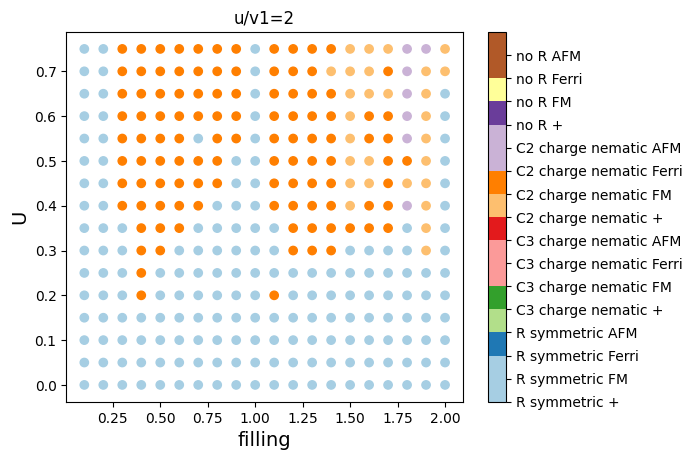

In [10]:
colorbar_ticks_combined = np.arange(len(phase_list_final))
cmap = plt.get_cmap("Paired", len(phase_list_final))
# plt.pcolormesh(e_fermi_mesh, u_mesh, phase_diagram_combined_op.T, cmap="Paired")
plt.scatter(filling_mesh, u_mesh, c=phase_diagram_based_on_d, cmap=cmap,vmin=0, vmax=len(phase_list_final))
# plt.xlabel(r'$E_{f}$', size = '14')
plt.xlabel('filling', size = '14')
plt.ylabel('U', size = '14')
# plt.xlim(3.8,6)
colorbar_ticks = np.arange(len(phase_list_final))
cbar = plt.colorbar()
cbar.set_ticks(colorbar_ticks)
cbar.set_ticklabels(phase_list_final)
plt.title('u/v1=2')

In [11]:
unique_phase_index = np.unique(phase_diagram_based_on_d)
unique_phase_name = [phase_list_final[i] for i in np.int_(unique_phase_index)]
filtered_phase_diagram = np.zeros(phase_diagram_based_on_d.shape)
for i in range(u_mesh.shape[0]):
    for j in range(u_mesh.shape[1]):
        filtered_phase_diagram[i,j] = np.where(unique_phase_index==phase_diagram_based_on_d[i,j])[0][0]

Text(0.5, 1.0, 'u/v1=2')

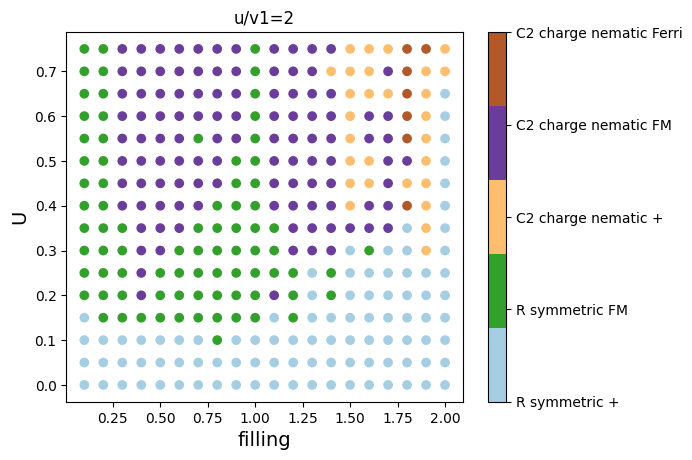

In [12]:
cmap = plt.get_cmap("Paired", len(unique_phase_index))
plt.scatter(filling_mesh, u_mesh, c=filtered_phase_diagram, cmap=cmap)
plt.xlabel('filling', size = '14')
plt.ylabel('U', size = '14')
colorbar_ticks = np.arange(len(unique_phase_index))
cbar = plt.colorbar()
cbar.set_ticks(np.arange(len(unique_phase_index)))
cbar.set_ticklabels(unique_phase_name)
plt.title('u/v1=2')

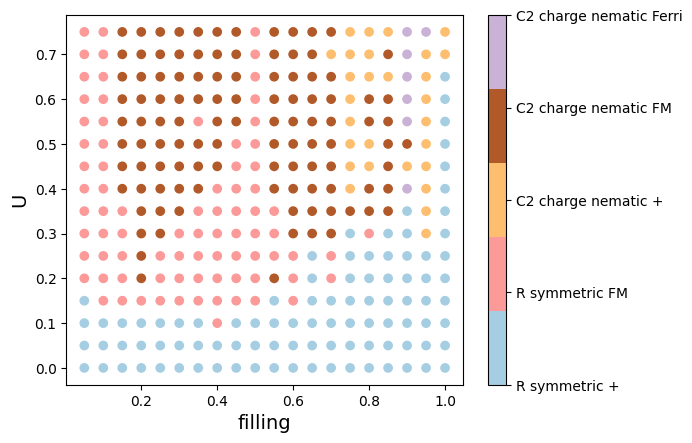

In [13]:
from matplotlib.colors import ListedColormap

paired = plt.get_cmap("Paired").colors
corlor_index = [0,4,6,11,8]
color_list = [paired[i] for i in corlor_index]

cmap = ListedColormap(color_list)
plt.scatter(filling_mesh/2, u_mesh, c=filtered_phase_diagram, cmap=cmap)
plt.xlabel('filling', size = '14')
plt.ylabel('U', size = '14')
colorbar_ticks = np.arange(len(unique_phase_index))
cbar = plt.colorbar()
cbar.set_ticks(np.arange(len(unique_phase_index)))
cbar.set_ticklabels(unique_phase_name)

In [14]:
filling_arr[-2]

np.float64(1.9)

In [15]:
sorted_ground_state_e[-2,-1]

array([-0.00729899, -0.00729898, -0.00729898, -0.0072175 , -0.0072175 ,
       -0.0072175 , -0.00721665, -0.00721665, -0.00721665, -0.00054986])

In [16]:
sorted_density[-2,-1,3]

array([[0.27210868-2.82417782e-25j, 0.40735718+8.20475028e-20j,
        0.27210829+1.53937916e-19j],
       [0.27037297+7.63828032e-26j, 0.4076803 -9.57154893e-21j,
        0.27037258+1.68266809e-20j]])

In [17]:
sorted_density[-2,-1,3,0]-sorted_density[-2,-1,3,1]

array([ 0.00173572-3.58800586e-25j, -0.00032311+9.16190518e-20j,
        0.00173571+1.37111235e-19j])

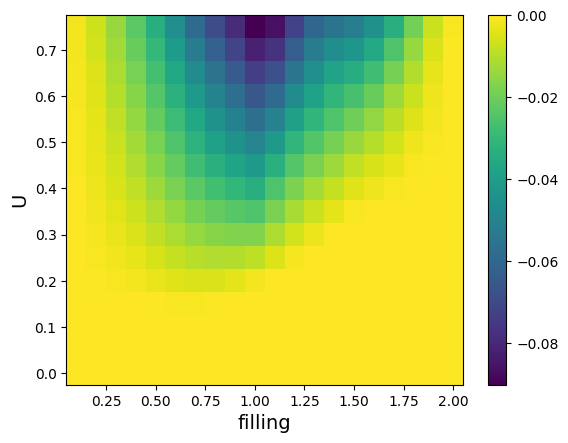

In [18]:
plt.pcolormesh(filling_mesh,u_mesh,sorted_ground_state_e[:,:,0])
plt.xlabel('filling', size = '14')
plt.ylabel('U', size = '14')
plt.colorbar()

### band structure plot

In [19]:
from functions_parameters.universal_parameters import a, b
from functions_parameters.jax_schf_helpers import *
from functions_parameters.bond_table_generator import build_buckets_per_shell
from functions_parameters.jax_schf_kernel import schf_single_job

In [20]:
num_bands = 3
mu = 2
t_nn = 1
t_nnn = -0.025
t_arr = np.array([t_nn, t_nnn])
temperature = 4E-4

# high-symmetry k-path
k_path = np.array([[0, 0],
                   [1 / 2, 0],
                   [1 / 3, 1 / 3],
                   [0, 0],
                   [0, 1 / 2],
                   [-1 / 3, 2 / 3],
                   [0, 0],
                   [-1 / 2, 1 / 2],
                   [-2 / 3, 1 / 3],
                   [0, 0]])
num_k = 30
# obtain the distance of each segment of k path
k_path_distance = [0, la.norm((k_path[1] - k_path[0]) @ b), ]
for i in range(k_path.shape[0] - 2):
    k_path_distance += [
        k_path_distance[-1] + la.norm((k_path[i + 2] - k_path[i + 1]) @ b)]
# obtain the distance for each point along k path for plotting
k_path_line = np.array(
    [np.linspace(k_path_distance[i], k_path_distance[i + 1], num_k) for i in range(len(k_path_distance) - 1)]).reshape(
    (-1))
high_symmetry_k = [k_path_line[num_k * i] for i in range(k_path.shape[0] - 1)]
high_symmetry_k += [k_path_line[-1], ]
# xticks_k = ['G', r'$M_{1}$', r'$K_{1}$', 'G', r'$M_{2}$', r'$K_{2}$', 'G', r'$M_{3}$', r'$K_{3}$', 'G']
xticks_k = ['G', r'$M_{1}$', r'$K_{1}$', 'G', r'$M_{2}$', r'$K_{2}$', 'G', r'$M_{3}$', r'$K_{3}$', 'G']
high_symmetry_spectrum = np.zeros((k_path_line.shape[0], num_bands))
k_points_along_path = np.vstack([np.linspace(k_path[i], k_path[i + 1], num_k) for i in range(k_path.shape[0] - 1)])
k_points_along_path = np.array([k @ b for k in k_points_along_path])

In [21]:
filling_index = -6
filling_i = filling_arr[filling_index]/2

In [22]:
filling_i

np.float64(0.75)

In [23]:
basis_frac = np.array([[1/2, 0], [1/2, 1/2], [0, 1/2]])
radii, a_lists, deltas = build_buckets_per_shell(a, basis_frac, 2)

phase_pos, phase_neg = precompute_k_phase_tables(deltas, a, k_points_along_path)
Htb, e_all, v_all, v_all_dagger = hk_all_k_from_phases(mu, a_lists, t_arr, phase_neg)
dict_ref = prepare_reference_state(filling_i, a_lists, Htb, e_all, v_all, v_all_dagger, phase_pos, phase_neg, temperature)

u_index = -1
u_input = u_arr[u_index]
v_arr = np.array((u_input, u_input))/2

input_d = sorted_density[filling_index, u_index,0]
input_bond = sorted_bond[filling_index, u_index,0]


In [24]:
# prepare the initial mean-field terms
h_mean_u = dict_ref['h_mean_u']
h_mean_v = dict_ref['h_mean_v']
h_mean_initial_u = h_mean_u*u_input
h_mean_initial = h_mean_initial_u[None, :, :, :] + np.einsum('Nsvmn,v->Nsmn', h_mean_v,v_arr)

# prepare the input mean-field terms
h_mean_input_u = mean_field_u(input_d, u_input)
h_mean_input_v_o = hartree_spinor(a_lists, v_arr, input_d)
h_mean_input_o = h_mean_input_u + h_mean_input_v_o
# k-dependent part
h_mean_input_v_k = fock_spinor(input_bond, v_arr, phase_pos)
h_mean_input = h_mean_input_o[None, :, :, :] + h_mean_input_v_k


spectrum_nematic = np.zeros((k_points_along_path.shape[0], num_bands*2))
spectrum_original = np.zeros((k_points_along_path.shape[0], num_bands))
for i in range(k_points_along_path.shape[0]):
    e_o, _= la.eigh(Htb[i])
    spectrum_original[i,:] = e_o
    hup = Htb[i] + h_mean_input[i,0] - h_mean_initial[i,0]
    e_up,_ = la.eigh(hup)
    hdn = Htb[i] + h_mean_input[i,1] - h_mean_initial[i,1]
    e_dn,_ = la.eigh(hdn)
    spectrum_nematic[i,:] = np.concatenate((e_up, e_dn))

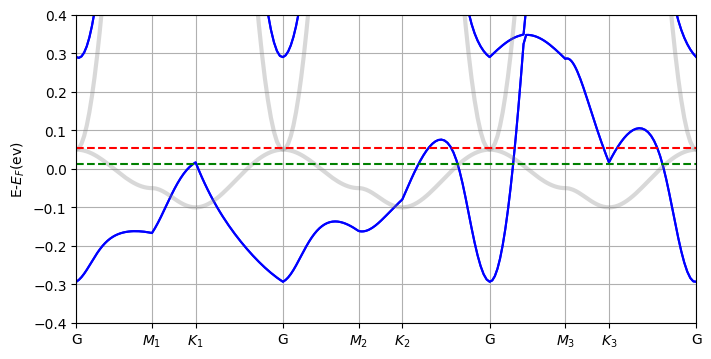

In [25]:
plt.figure(figsize=(8, 4))
plt.plot(k_path_line, spectrum_nematic, 'b-')
plt.plot(k_path_line, spectrum_original, 'grey', alpha = 0.3, linewidth=3)
plt.hlines(dict_ref['e_fermi'], high_symmetry_k[0], high_symmetry_k[-1], colors='green', linestyles='--')
plt.hlines(sorted_e_fermi[filling_index, u_index,0], high_symmetry_k[0], high_symmetry_k[-1], colors='red', linestyles='--')
plt.xlim(high_symmetry_k[0], high_symmetry_k[-1])
plt.ylim(-0.4,0.4)
plt.xticks(high_symmetry_k, xticks_k)
plt.ylabel('E-' + r'$E_{F}$' + '(ev)')
# plt.title(
#     'Band structure of rotated ' + r'$d_{yz}$' + ' and ' + r'$d_{x^{2}-y^{2}}$' + ' with SOC strength %i' % soc_strength)
# plt.ylim(-0.1, 0.04)
plt.grid()

In [26]:
sorted_e_fermi[filling_index, u_index,0]

np.float64(0.05370200206373284)